# 目标检测

> 主要基于锚框算法

## R-CNN

- 使用启发式搜索算法得到锚框
- 使用预训练模型对每一个锚框抽取特征
- 使用SVM分类
- 训练线性回归模型预测偏移

锚框大小不一样？

- 兴趣区域池化
    - 锚框分成$n\times m$个块
    - 给出块中的最大值
    - 不管锚框多大，总是输出nm个值
    
## Fast R-CNN

- 使用CNN抽取特征（不是对锚框抽特征），得到特征图
- 选取锚框，映射道特征图，再进行RoL的抽取特征得到固定长度的特征
- 最后全连接预测

## Faster R-CNN

- 使用区域提议网络代替启发式搜索
    - 使用一个小的网络，在一堆差的锚框中，预测一个比较好的锚框
- Two-stage

## Mask R-CNN

- 如果存在像素级变化，使用FCN利用这些信息
- 像素级预测不用使用ROI Pooling，而是使用ROI align(使用像素的加权平均)
    - 防止边界错位
    
> `Faster R-CNN` 以及 `Mask R-CNN` 是追求高精度场景下的常用算法

# 单发多框检测(SSD)

> RNN Two-stage, SSD Single-stage

- 以每一个像素为中心生产锚框
- 直接对锚框做预测
    - 使用底层网络抽取特征，多个卷积层高宽减半
    - 每一次都生成锚框
        - 底层锚框拟合小物体
        - 顶层锚框拟合大物体
- 每一层都预测类以及偏移

# YOLO

You only life once? **You only look once**

- SSD中存在大量锚框的重合，浪费大量的计算,YOLO让锚框不重叠
    - YOLO将图片均分成$S\times S$个锚框
    - 每个锚框预测B个边缘框

# 非锚框

- 使用像素级预测：
    - center net
    

# QA

- 多模型融合可以提高精度
- R-CNN 会改变锚框，而YOLO不会改变锚框
    - 锚框使用的是相对大小$h,w\in(0,1)$，和图片的大小无关
- 目标检测对最后的特征图要求不高，因为最后不需要变成向量

# SSD的实现

In [1]:
%matplotlib inline
import torch
import os
import numpy as np
from PIL import Image
from d2l import torch as d2l
from matplotlib import pyplot as plt

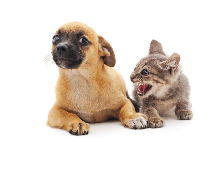

In [2]:
img = np.array(Image.open(os.path.join('.', 'img', 'catdog.jpg')))
h, w = img.shape[:2]
plt.rcParams["figure.figsize"]=(3.5, 2.5)
plt.axis("off")
plt.imshow(img)
plt.show()

In [3]:
def display_anchors(fmap_w, fmap_h, s):
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(
        fmap,
        sizes=s,
        ratios=[1, 2, 0.5]
    )
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes, anchors[0] * bbox_scale)

/home/maxsola/miniconda3/envs/torch/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


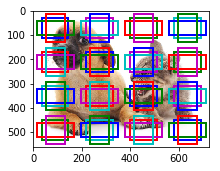

In [4]:
display_anchors(4, 4, [0.15])

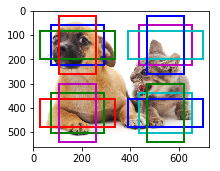

In [5]:
display_anchors(2, 2, [0.3])

In [6]:
# SSD
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [7]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1)
# 类似于NiN里面使用卷积替代全连接层，
# 输出的每一个像素点生成的每一个锚框对每一个类别（类别包含背景）的预测值

In [8]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)
# 边框的偏移预测，每一个像素点需要给出4个值的偏移量

In [9]:
# 连接多尺度预测
def forward(x, block):
    return block(x)
# 只有 batch_size 是不变的 channels_size height width 都会变
Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [10]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)
    # 使得预测值连续
    
def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [11]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [12]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros(2, 3, 256, 256), base_net()).shape

torch.Size([2, 64, 32, 32])

In [13]:
# 分成5个阶段，每个阶段做一次目标检测
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [14]:
# 前向计算
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [15]:
sizes= [
    [0.2, 0.272],
    [0.37, 0.447],
    [0.54, 0.619],
    [0.71, 0.79],
    [0.88, 0.961]
]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [16]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, sizes, ratios, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.sizes = sizes
        self.ratios = ratios
        num_anchors = len(sizes[0]) + len(ratios[0]) - 1
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i], num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i], num_anchors))

    def forward(self, X):
        # 总共有5个stage
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X,
                getattr(self, f'blk_{i}'),
                self.sizes[i],
                self.ratios[i],
                getattr(self, f'cls_{i}'),
                getattr(self, f'bbox_{i}')
            )
        anchors = torch.cat(anchors, dim=1)
        # 将 类 单独列出来 便于Softmax
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds 
    # 不需要最后的卷积输出 而是每一层的预测输出

In [17]:
net = TinySSD(1, sizes, ratios)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('anchors:', anchors.shape)
print('class preds:', cls_preds.shape)
print('bbox_preds', bbox_preds.shape)
# 锚框总数为5444

anchors: torch.Size([1, 5444, 4])
class preds: torch.Size([32, 5444, 2])
bbox_preds torch.Size([32, 21776])


In [18]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [19]:
device, net = d2l.try_gpu(), TinySSD(1, sizes, ratios)
trainer = torch.optim.SGD(net.parameters(), lr=0.1, weight_decay=5e-4)

In [20]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none') 
# 使用L1而不是L2是防止预测过远时loss巨大

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    # 展平批量
    cls = cls_loss(cls_preds.reshape(-1, num_classes), cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    # 使用 bbox_masks 屏蔽锚框的偏移
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float(
        torch.abs((bbox_labels - bbox_preds) * bbox_masks).sum()
    )

class err 3.39e-03, bbox mae 3.50e-03
9061.2 examples/sec on cuda:0


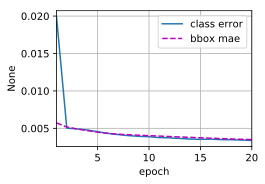

In [21]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['class error', 'bbox mae'])

net = net.to(device)

for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        anchors, cls_preds, bbox_preds = net(X)
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(
            cls_eval(cls_preds, cls_labels),
            cls_labels.numel(),
            bbox_eval(bbox_preds, bbox_labels, bbox_masks),
            bbox_labels.numel()
        )
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

In [22]:
X = torchvision.io.read_image('./img/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).type(torch.uint8)


# 使用 NMS 抑制输出
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

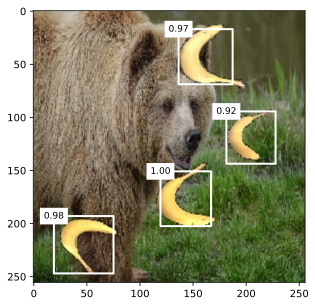

In [23]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)